In [54]:
import numpy as np
import pandas as pd

In [2]:
import tensorflow as tf
from tensorflow import keras

#### Making ResNet model using keras api's

In [18]:
class ResedialUnit(keras.layers.Layer):
    
    def __init__(self, filters, strides=1, activation="relu", **kwargs):
        super().__init__(**kwargs)
        self.activation = keras.activations.get(activation)
        self.main  = [keras.layers.Conv2D(filters, 3, strides=strides, padding="same", use_bias=False), 
                     keras.layers.BatchNormalization(),
                     self.activation,
                     keras.layers.Conv2D(filters, 3, strides=1, padding="same", use_bias=False), 
                     keras.layers.BatchNormalization()]
        self.skips = []
        if strides > 1:
            self.skips  = [keras.layers.Conv2D(filters, 1, strides=strides, padding="same", use_bias=False),
                          keras.layers.BatchNormalization()]
    
    def call(self, inputs):
        z = inputs
        for layer in self.main:
            z = layer(z)
        skip_z = inputs
        for layer in self.skips:
            skip_z = layer(skip_z)
        return self.activation(z + skip_z)

In [20]:
model = keras.models.Sequential()
model.add(keras.layers.Conv2D(64, 7, strides=2, input_shape=[234, 234, 3], padding="same", use_bias=False))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Activation("relu"))
model.add(keras.layers.MaxPool2D(pool_size=3, strides=2, padding="same"))
prev_filter = 64
for filters in [64] * 3 + [128] * 4 + [256] * 6 + [512] * 3:
    strides = 1 if filters == prev_filter else 2
    model.add(ResedialUnit(filters, strides=strides))
    prev_filter = filters
model.add(keras.layers.GlobalAveragePooling2D())
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(1000, activation="softmax"))

#### Using pretrained model from keras

In [21]:
model = keras.applications.resnet50.ResNet50(weights="imagenet")

102981632/102967424 [==============================] - 9s 0us/step


In [28]:
import os
if "CNN" in os.path.abspath(os.curdir): os.chdir("..")
BASE_DIR = os.path.abspath(os.curdir)
BASE_DIR

'D:\\TheCompleteML\\projects'

In [30]:
from sklearn.datasets import load_sample_image
sample_image = load_sample_image("flower.jpg")

In [62]:
sample_image = sample_image.reshape(1, 427, 640, 3)
print(sample_image.shape, np.max(sample_image[0][:, 1, 1])) 

(1, 427, 640, 3) 103


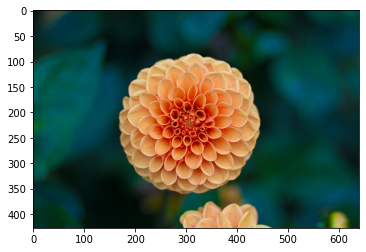

In [47]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.imshow(sample_image[0])
plt.show()

In [48]:
resized = tf.image.resize(sample_image, [224, 224])

In [50]:
resized.shape

TensorShape([1, 224, 224, 3])

In [56]:
y_probas = model.predict(resized)
top_k = keras.applications.resnet50.decode_predictions(y_probas, top=3)

49152/35363 [=========================================] - 0s 1us/step


In [57]:
for item in top_k:
    print(item)

[('n02206856', 'bee', 0.34621933), ('n03530642', 'honeycomb', 0.24887945), ('n04522168', 'vase', 0.121104136)]


### Tranfer Learning for CNN

In [66]:
import tensorflow_datasets as tfds

In [67]:
dataset, info = tfds.load("tf_flowers", as_supervised=True, with_info=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling C:\Users\kaush\tensorflow_datasets\tf_flowers\3.0.1.incomplete6K97ZA\tf_flowers-train.tfrecord*...: …

Dataset tf_flowers downloaded and prepared to C:\Users\kaush\tensorflow_datasets\tf_flowers\3.0.1. Subsequent calls will reuse this data.


In [70]:
dataset_size = info.splits["train"].num_examples
dataset_size

3670

In [72]:
class_names = info.features["label"].names
class_names

['dandelion', 'daisy', 'tulips', 'sunflowers', 'roses']

In [74]:
num_classes = info.features["label"].num_classes
num_classes

5

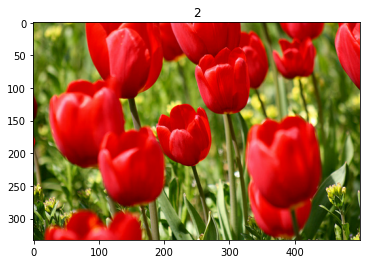

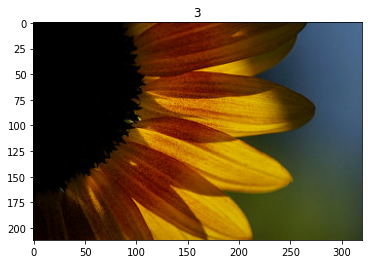

In [99]:
for item in dataset["train"].take(2):
    plt.title(item[1].numpy())
    plt.imshow(item[0])
    plt.show()

In [102]:
test_set_raw, valid_set_raw, train_set_raw = tfds.load("tf_flowers", 
                                                       split = ["train[:10%]", "train[10%:25%]", "train[25%:]"], 
                                                       as_supervised = True)

In [106]:
def preprocess(image, label):
    resized = tf.image.resize(image, [224, 224])
    final = keras.applications.xception.preprocess_input(resized)
    return final, label

In [108]:
batch_size = 32
train_set = train_set_raw.shuffle(1000)
train_set = train_set.map(preprocess).batch(batch_size).prefetch(1)
valid_set = valid_set_raw.map(preprocess).batch(batch_size).prefetch(1)
test_set = test_set_raw.map(preprocess).batch(batch_size).prefetch(1) 

In [110]:
base_model = keras.applications.xception.Xception(weights="imagenet", include_top=False)
avg = keras.layers.GlobalAveragePooling2D()(base_model.output)
output = keras.layers.Dense(num_classes, activation="softmax")(avg)
model = keras.Model(inputs=base_model.input, outputs=output)

In [118]:
base_model.summary()

Model: "xception"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 block1_conv1 (Conv2D)          (None, None, None,   864         ['input_3[0][0]']                
                                32)                                                               
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, None, None,   128        ['block1_conv1[0][0]']           
 ation)                         32)                                                        

In [119]:
# make layers of base_model non-trainable for some epochs
for layer in base_model.layers:
    layer.trainable = False

In [121]:
# here epoch is one to observe a time taken by model in actual it can be around 5
optimizer = keras.optimizers.SGD(lr = 0.2, momentum = 0.9, decay = 0.01) 
model.compile(loss ="sparse_categorical_crossentropy", 
              optimizer = optimizer, 
              metrics =["accuracy"]) 
history = model.fit(train_set, epochs = 1, validation_data = valid_set)

86/86 [==============================] - 217s 2s/step - loss: 1.5534 - accuracy: 0.7852 - val_loss: 1.1585 - val_accuracy: 0.8367


##### Observations

Here, we trined a model with only one epoch and still got the validation accuracy of 0.83 which is good. But in general, we should train a model up to 5 epochs by making base models layer to not-trainable. Once outer layers gets trained then make the necessory adjustment to lr, making base model layers trainables and other parameters if needed and train the model for more numbers of epochs.

Indeed, model takes around 3.5 minutes for one epoch without base model layers. We should also count the amount of time may needed for an epoch with base model layers

### Classification and localization

In [123]:
base_model = keras.applications.xception.Xception(weights="imagenet", include_top=False)
avg = keras.layers.GlobalAveragePooling2D()(base_model.output)
class_output = keras.layers.Dense(num_classes, activation="softmax")(avg)
location_output = keras.layers.Dense(4)(avg)

model = keras.Model(inputs=base_model.input, outputs=[class_output, location_output])

#### Observations

Here, location output has four neurons each of them responsible for the horizontal cordinate of center of object, vertical cordinate of center of object, height and width.

In [127]:
model.compile(loss=["sparse_categorical_crossentropy", "mse"],
             loss_weights=[0.8, 0.2], # depends which we care most
             optimizer=optimizer)

##### Note

It is important to have a labeled data with objects having bounding box for training. Once we have data with class labels and bounding box then we can train a model with (images, (class_labels, bounding_boxes)) formats of data.

bouding box should be normalized between o and 1.

### Object Detections